Q1. iris data를 불러와서 아래 사항을 수행하세요.

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

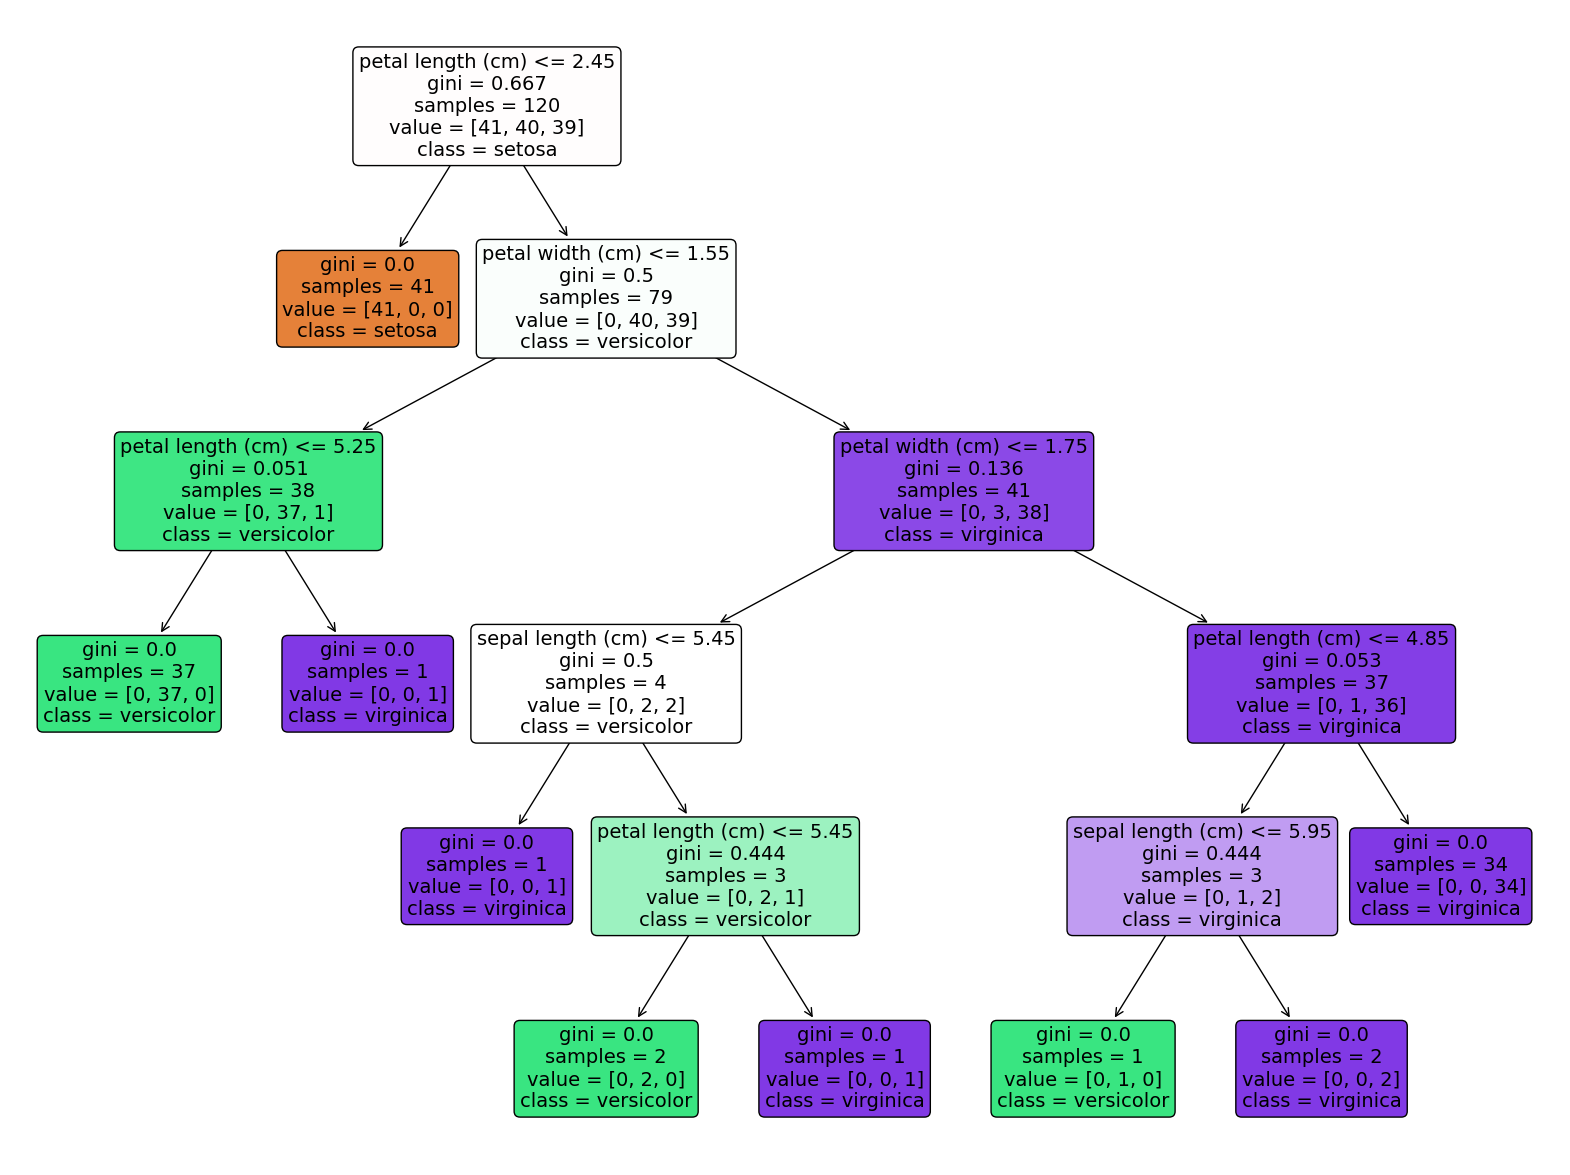

In [2]:
# 데이터 불러와서 결정 트리 모델 학습, 예측 수행
dt_clf = DecisionTreeClassifier(random_state=156)
iris_data = load_iris()
xtrain, xtest, ytrain, ytest = train_test_split(iris_data.data, iris_data.target,
                                               test_size = 0.2, random_state = 11)
dt_clf.fit(xtrain, ytrain)


# 결정트리 모델 시각화
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
tree.plot_tree(dt_clf, filled=True,
              feature_names=iris_data.feature_names,
              class_names=iris_data.target_names,
              rounded=True, fontsize=14)
plt.show()
plt.close()

# petal <= 2.45 가 일차적인 분류 

feature importances: 
[0.025 0.    0.555 0.42 ]
sepal length (cm) :  0.025
sepal width (cm) :  0.000
petal length (cm) :  0.555
petal width (cm) :  0.420


<AxesSubplot:>

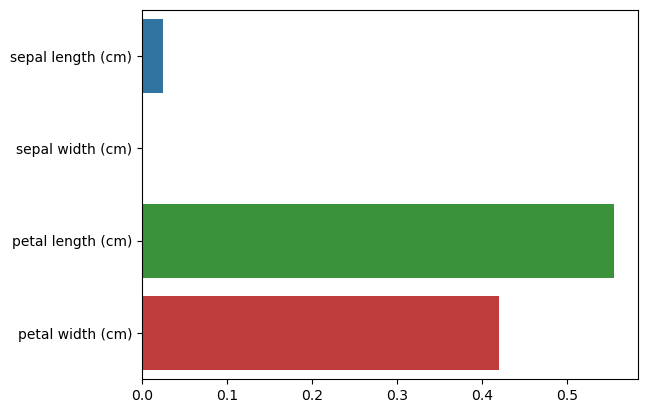

In [3]:
# Feature importance를 추출하고 시각화하세요.

import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출
print("feature importances: \n{0}".format(np.round(dt_clf.feature_importances_,3)))

# feature 별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1: .3f}'.format(name, value))
    
# feature importance를 column 별로 시각화 하기
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('C:\hmkd1\m5_ml\머신러닝03_평가/dataset/creditcard.csv')

In [7]:
# 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
def get_df(df=None):
    df = card_df.copy()
    df.drop('Time', axis=1, inplace=True)
    return df

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
def get_train_test_dataset(df=None):
    df = get_df(df)
    xfeatures = df.iloc[:, :-1]
    ytarget = df.iloc[:, -1]
    xtrain, xtest, ytrain, ytest = train_test_split(xfeatures, ytarget, test_size=0.3, random_state=0, stratify=ytarget)
    return xtrain, xtest, ytrain, ytest

xtrain, xtest, ytrain, ytest = get_train_test_dataset(card_df)

# 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(xtrain, ytrain)
lr_pred = lr_clf.predict(xtest)
lr_pred_proba = lr_clf.predict_proba(xtest)[:, 1]

def get_clf_eval(ytest, pred, pred_proba):
    confusion = confusion_matrix(ytest, pred)
    accuracy = accuracy_score(ytest, pred)
    precision = precision_score(ytest, pred)
    recall = recall_score(ytest, pred)
    f1 = f1_score(ytest, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1 score: {3:.4f}'.format(accuracy, precision, recall, f1))

get_clf_eval(ytest, lr_pred, lr_pred_proba)


오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, f1 score: 0.7194


In [9]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행

def get_model_train_eval(model,ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    
# 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 
# 단, n_estimators=1000, num_leaves=64 적용

from lightgbm import LGBMClassifier

# ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). 
# default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=xtrain, ftr_test=xtest, tgt_train=ytrain, tgt_test=ytest)


# 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는 사용자 함수 생성
def get_preprocessed_df(df=None):
    df = df.copy()
    amount_n = np.log1p(df['Amount'])
    df.insert(0, 'Amount_Scaled', amount_n)
    df.drop(['Time','Amount'], axis=1, inplace=True)
    return df

# Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

xtrain, xtest, ytrain, ytest = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, ftr_train=xtrain, ftr_test=xtest, tgt_train=ytrain, tgt_test=ytest)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=xtrain, ftr_test=xtest, tgt_train=ytrain, tgt_test=ytest)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1 score: 0.8453
로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, f1 score: 0.7194
LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1 score: 0.8453


Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요

- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

<AxesSubplot:>

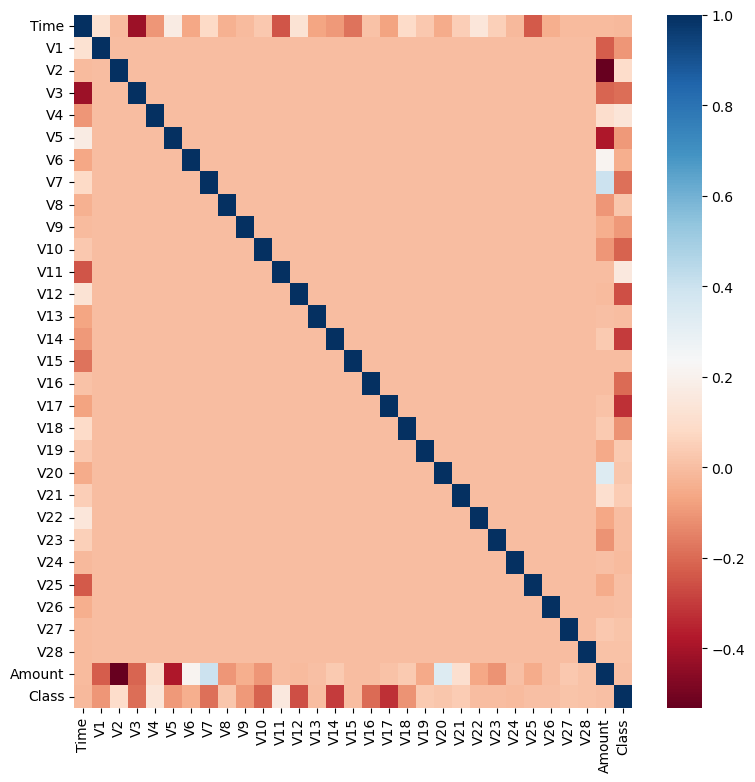

In [10]:
# 히트맵을 이용해 레이블과의 상관성을 시각화

import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [12]:
# 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

# 사용자 함수를 이용하여 이상치 검출
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스: ', outlier_index)

이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [13]:
# 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('로지스틱 회귀 예측 성능')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, f1 score: 0.7194
LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1 score: 0.8453


Q5. 신용카드 데이터에 SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.

In [15]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\h\Anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2022.10  |           py39_2          68 KB
    anaconda-custom            |           py39_1           4 KB
    ca-certificates-2023.5.7   |       h56e8100_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    conda-22.9.0               |   py39hcbf5309_2         985 KB  conda-forge
    imbalanced-learn-0.10.1    |     pyhd8ed1ab_0         131 KB  conda-forge
    openssl-1.1.1q             |       h8ffe710_0         5.8 MB  conda-forge
    pooch-1.7.0                |     pyh


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::datashader==0.14.1=py39haa95532_0
  - defaults/win-64::gensim==4.1.2=py39hd77b12b_0
  - defaults/win-64::scikit-image==0.19.2=py39hf11a4ad_0
  - defaults/win-64::scikit-learn-intelex==2021.6.0=py39haa95532_0
  - defaults/win-64::statsmodels==0.13.2=py39h2bbff1b_0


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::datashader==0.14.1=py39haa95532_0
  - defaults/win-64::gensim==4.1.2=py39hd77b12b_0
  - defaults/win-64::scikit-image==0.19.2=py39hf11a4ad_0
  - defaults/win-64:

In [17]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ImportError: cannot import name '_astype_copy_false' from 'sklearn.utils.fixes' (C:\Users\h\Anaconda3\lib\site-packages\sklearn\utils\fixes.py)

Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# 데이터셋의 타겟 이름을 'PRICE'로 지정
bostonDF['PRICE'] = boston.target



Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.

- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

In [18]:
import pandas as pd
house_df = pd.read_pickle('C:\hmkd1\m5_ml/dataset/house_df.pkl')

Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

data = datasets.load_boston()

Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_csv('dataset/mtcars.csv',index_col=0)

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 

In [31]:
# df.to_csv('./dataset/purdata.csv',index=False)
df = pd.read_csv('./dataset/purdata.csv')
df.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,1,*,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,3,*,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0
